In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [45]:
# Initialize properties and load weather data
print('Initializing properties and loading weather data...')
a = 6  # Short side [m]
b = 16  # Long side [m]
alpha_degrees = 60  # Slope angle below surface
beta_degrees = 45  # Slope angle above surface
d = 2  # Pit depth [m]
h = 2  # Pile height [m]
beta = beta_degrees * np.pi / 180  # [rad]
alpha = alpha_degrees * np.pi / 180  # [rad]
Dw = 1000  # Density of water [kg m-3]
Ds = 750  # Density of snow [kg m-3]
Ls = 334000  # Latent heat of fusion [J kg-1]
cw = 4185  # Heat capacity [J kg-1 K-1]
lambda_i = 0.1  # Sawdust thermal conductivity [W m-1 K-1]
lambda_g = 1  # Ground thermal conductivity [W m-1 K-1]
thickness = 0.1  # Insulation layer thickness
Prop = [a, b, alpha, beta, d, h, Dw, Ds, Ls, cw, lambda_i, lambda_g, thickness]
Prop0 = Prop.copy()

aa = Prop[0]
bb = Prop[1]
dd = Prop[4]
hh = Prop[5]

Initializing properties and loading weather data...


In [46]:
aa

6

In [47]:
# Load weather data
filename1 = 'Weather_Montreal_2018.xlsx'
Table_weather = pd.read_excel(filename1)    # pip/conda install openpyxl
print('Weather data loaded successfully.')

Weather data loaded successfully.


In [48]:
# Functions
def Geometry(Prop):
    a = Prop[0]
    b = Prop[1]
    alpha = Prop[2]
    beta = Prop[3]
    d = Prop[4]
    h = Prop[5]

    # Volume
    Vol_surf = (h / 3) * ((a * b) + (a - 2 * h / np.tan(beta)) * (b - 2 * h / np.tan(beta)) + np.sqrt((a * b) * (a - 2 * h / np.tan(beta)) * (b - 2 * h / np.tan(beta))))
    Vol_below = (d / 3) * ((a * b) + (a - 2 * d / np.tan(alpha)) * (b - 2 * d / np.tan(alpha)) + np.sqrt((a * b) * (a - 2 * d / np.tan(alpha)) * (b - 2 * d / np.tan(alpha))))
    Vol_tot = Vol_below + Vol_surf

    # Area
    a_surf = (a - 2 * h / np.tan(beta)) * (b - 2 * h / np.tan(beta)) + (h / np.sin(beta)) * (2 * a + 2 * b + 2 * (a - 2 * h / np.tan(beta)) + 2 * (b - 2 * h / np.tan(beta))) / 2
    a_below = (a - 2 * d / np.tan(alpha)) * (b - 2 * d / np.tan(alpha)) + (d / np.sin(alpha)) * ((2 * a + 2 * b) + 2 * (a - 2 * d / np.tan(alpha)) + 2 * (b - 2 * d / np.tan(alpha))) / 2

    return [Vol_surf, Vol_below, Vol_tot, a_surf, a_below]

In [49]:
def GeometryOpt(Prop):
    a, b, alpha, beta, d, h = Prop[:6]

    # Precompute common terms
    tan_beta = np.tan(beta)
    tan_alpha = np.tan(alpha)
    sin_beta = np.sin(beta)
    sin_alpha = np.sin(alpha)

    # Volume calculations
    term_surf = (a - 2 * h / tan_beta) * (b - 2 * h / tan_beta)
    sqrt_surf = np.sqrt((a * b) * term_surf)
    Vol_surf = (h / 3) * ((a * b) + term_surf + sqrt_surf)

    term_below = (a - 2 * d / tan_alpha) * (b - 2 * d / tan_alpha)
    sqrt_below = np.sqrt((a * b) * term_below)
    Vol_below = (d / 3) * ((a * b) + term_below + sqrt_below)

    Vol_tot = Vol_below + Vol_surf

    # Area calculations
    a_surf = term_surf + (h / sin_beta) * (2 * a + 2 * b + 2 * (a - 2 * h / tan_beta) + 2 * (b - 2 * h / tan_beta)) / 2
    a_below = term_below + (d / sin_alpha) * ((2 * a + 2 * b) + 2 * (a - 2 * d / tan_alpha) + 2 * (b - 2 * d / tan_alpha)) / 2

    return [Vol_surf, Vol_below, Vol_tot, a_surf, a_below]

In [50]:
# Calculate initial geometry
Geo = Geometry(Prop)
Vi = Geo[0] + Geo[1]  # Initial volume of snow
Vi0 = Geo[0] + Geo[1]  # Initial volume of snow
mass = Vi * Ds

Vf = np.zeros(6)
Tair = Table_weather.iloc[:, 13].values  # Diurnal air mean temperature above freezing point [ºC]
Tmax = Table_weather.iloc[:, 9].values
P = Table_weather.iloc[:, 19].values  # Total Rain [mm]
s = Tair.shape
P[np.isnan(P)] = 0
print('Initialization complete.')

Initialization complete.


In [51]:
Geo

[111.99999999999997,
 144.11490884035777,
 256.11490884035777,
 125.82337649086283,
 141.47349035535373]

In [59]:
%%timeit
Geo = Geometry(Prop)

16.8 μs ± 988 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [60]:
%%timeit
GeoOpt = GeometryOpt(Prop)
#GeoOpt

6.73 μs ± 262 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [53]:
def Melted_Volume(Temp, Rain, Prop, day):
    a = Prop[0]
    b = Prop[1]
    alpha = Prop[2]
    beta = Prop[3]
    d = Prop[4]
    h = Prop[5]
    Dw = Prop[6]
    Ds = Prop[7]
    Ls = Prop[8]
    cw = Prop[9]
    lambda_i = Prop[10]
    lambda_g = Prop[11]
    thickness = Prop[12]

    # Surface melt
    if h > 0:
        A = (a - 2 * h / np.tan(beta)) * (b - 2 * h / np.tan(beta)) + (h / np.sin(beta)) * ((2 * a + 2 * b) + 2 * (a - 2 * h / np.tan(beta)) + 2 * (b - 2 * h / np.tan(beta))) / 2
    else:
        A = (a - 2 * abs(h) / np.tan(alpha)) * (b - 2 * abs(h) / np.tan(alpha))

    Ag = (a - 2 * d / np.tan(alpha)) * (b - 2 * d / np.tan(alpha)) + (d / np.sin(alpha)) * ((2 * a + 2 * b) + 2 * (a - 2 * d / np.tan(alpha)) + 2 * (b - 2 * d / np.tan(alpha))) / 2

    if Temp <= 0:
        Q_surf = 0
    else:
        Q_surf = A * (lambda_i / thickness) * Temp  # Thermal flow [W]

    v_surf = Q_surf / (Ls * Ds)  # [m3 s-1]
    V_surf = v_surf * (3600 * 24)  # [m3 day-1]

    # Rain melt
    V_rain = ((Rain / 1000) * A * Dw * cw * Temp) / (Ls * Ds)  # P[m],T[K], cs [J kg-1 K-1]

    # Ground melt
    Q_ground = lambda_g * Ag * 2  # Thermal flow [W]
    v_ground = Q_ground / (Ls * Ds)  # [m3 s-1]
    V_ground = v_ground * (3600 * 24)  # [m3 day-1]

    # Snowmelt for cooling
    if day in [177, 225]:
        V_cool = 0.01 * 200
    elif day in [178, 226]:
        V_cool = 0.015 * 200
    elif day in [179, 227]:
        V_cool = 0.020 * 200
    elif day in [180, 228]:
        V_cool = 0.025 * 200
    elif day in [181, 229]:
        V_cool = 0.030 * 200
    elif day in [182, 230]:
        V_cool = 0.035 * 200
    elif day in [183, 231]:
        V_cool = 0.040 * 200
    elif day in [184, 232]:
        V_cool = 0.045 * 200
    else:
        V_cool = 0

    # Total snowmelt
    V_melt = V_surf + V_rain + V_ground + V_cool
    V_melt0 = V_surf + V_rain + V_ground

    return V_melt, V_melt0, V_surf, V_rain, V_ground, V_cool

In [61]:
def Melted_VolumeOpt(Temp, Rain, Prop, day):
    a, b, alpha, beta, d, h, Dw, Ds, Ls, cw, lambda_i, lambda_g, thickness = Prop

    # Precompute common terms
    tan_beta = np.tan(beta)
    tan_alpha = np.tan(alpha)
    sin_beta = np.sin(beta)
    sin_alpha = np.sin(alpha)

    # Surface area
    if h > 0:
        A = (a - 2 * h / tan_beta) * (b - 2 * h / tan_beta) + (h / sin_beta) * (2 * a + 2 * b + 2 * (a - 2 * h / tan_beta) + 2 * (b - 2 * h / tan_beta)) / 2
    else:
        A = (a - 2 * abs(h) / tan_alpha) * (b - 2 * abs(h) / tan_alpha)

    # Ground area
    Ag = (a - 2 * d / tan_alpha) * (b - 2 * d / tan_alpha) + (d / sin_alpha) * ((2 * a + 2 * b) + 2 * (a - 2 * d / tan_alpha) + 2 * (b - 2 * d / tan_alpha)) / 2

    # Surface melt
    Q_surf = A * (lambda_i / thickness) * Temp if Temp > 0 else 0
    V_surf = (Q_surf / (Ls * Ds)) * (3600 * 24)

    # Rain melt
    V_rain = ((Rain / 1000) * A * Dw * cw * Temp) / (Ls * Ds)

    # Ground melt
    Q_ground = lambda_g * Ag * 2
    V_ground = (Q_ground / (Ls * Ds)) * (3600 * 24)

    # Snowmelt for cooling
    cooling_days = {177: 0.01, 178: 0.015, 179: 0.020, 180: 0.025, 181: 0.030, 182: 0.035, 183: 0.040, 184: 0.045}
    V_cool = cooling_days.get(day, 0) * 200

    # Total snowmelt
    V_melt = V_surf + V_rain + V_ground + V_cool
    V_melt0 = V_surf + V_rain + V_ground

    return V_melt, V_melt0, V_surf, V_rain, V_ground, V_cool

In [67]:
%%timeit
V_melt, V_melt0, V_surf, V_rain, V_ground, V_cool = Melted_Volume(Tair[0], P[0], Prop, 0 + 1)

7.7 μs ± 298 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [68]:
%%timeit
V_melt, V_melt0, V_surf, V_rain, V_ground, V_cool = Melted_VolumeOpt(Tair[0], P[0], Prop, 0 + 1)

5.81 μs ± 228 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [63]:
def calculateHeight(V, V_offset, a, b, angle):
    h_max = np.tan(angle) * a / 2.0 * 50.0
    Vol_matrix = np.array([(i / 100 / 3) * ((a * b) + (a - 2 * i / 100 / np.tan(angle)) * (b - 2 * i / 100 / np.tan(angle)) + np.sqrt((a * b) * (a - 2 * i / 100 / np.tan(angle)) * (b - 2 * i / 100 / np.tan(angle)))) for i in range(1, int(h_max) + 1)])
    k = np.polyfit(Vol_matrix, np.arange(1, int(h_max) + 1), 1)
    h = (V - V_offset) / (k[0] * 100)
    return h

In [64]:
def calculateHeightOpt(V, V_offset, a, b, angle):
    h_max = int(np.tan(angle) * a / 2.0 * 50.0)
    i_values = np.arange(1, h_max + 1)
    Vol_matrix = (i_values / 100 / 3) * ((a * b) + (a - 2 * i_values / 100 / np.tan(angle)) * (b - 2 * i_values / 100 / np.tan(angle)) + np.sqrt((a * b) * (a - 2 * i_values / 100 / np.tan(angle)) * (b - 2 * i_values / 100 / np.tan(angle))))
    k = np.polyfit(Vol_matrix, i_values, 1)
    h = (V - V_offset) / (k[0] * 100)
    return h

In [65]:
def findHeightNew(V, Prop):
    a = Prop[0]
    b = Prop[1]
    alpha = Prop[2]
    beta = Prop[3]
    d = Prop[4]

    Vol_below = (d / 3) * ((a * b) + (a - 2 * d / np.tan(alpha)) * (b - 2 * d / np.tan(alpha)) + np.sqrt((a * b) * (a - 2 * d / np.tan(alpha)) * (b - 2 * d / np.tan(alpha))))

    if V > Vol_below:
        h_new = calculateHeight(V, Vol_below, a, b, beta)
    else:
        h_new = -calculateHeight(Vol_below - V, 0, a, b, alpha)

    return h_new

In [ ]:
# Main loop with cooling
print('Starting main loop with cooling...')
num_of_days = s[0]
Vf2 = np.zeros((len(Vf), num_of_days))  # Preallocating for speed
Vnew2 = np.zeros(num_of_days)  # Preallocating for speed
storeh = np.zeros(num_of_days)  # Preallocating for speed
for i in range(s[0]):
    Temp = Tair[i]
    Rain = P[i]
    day = i + 1

    V_melt, V_melt0, V_surf, V_rain, V_ground, V_cool = Melted_Volume(Temp, Rain, Prop, day)

    Vf2[:, i] = [V_melt, V_melt0, V_surf, V_rain, V_ground, V_cool]
    Vnew2[i] = Vi - Vf2[0, i]  # NB! Vf2[0, i] = V_melt

    Vi = Vnew2[i]

    h_new = findHeightNew(Vnew2[i], Prop)  # More optimized function use
    storeh[i] = h_new

    Prop[5] = h_new
print('Main loop with cooling completed.')

Starting main loop with cooling...


UnboundLocalError: cannot access local variable 'Vi' where it is not associated with a value

In [56]:
# Main loop without cooling
print('Starting main loop without cooling...')
Vf0 = np.zeros((len(Vf), num_of_days))  # Preallocating for speed
Vnew0 = np.zeros(num_of_days)  # Preallocating for speed
storeh0 = np.zeros(num_of_days)  # Preallocating for speed
for i in range(s[0]):
    Temp = Tair[i]
    Rain = P[i]
    day = i + 1

    V_melt, V_melt0, V_surf, V_rain, V_ground, V_cool = Melted_Volume(Temp, Rain, Prop0, day)

    Vf0[:, i] = [V_melt, V_melt0, V_surf, V_rain, V_ground, V_cool]
    Vnew0[i] = Vi0 - Vf0[1, i]  # NB! Vf0[1, i] = V_melt0

    Vi0 = Vnew0[i]

    h_new0 = findHeightNew(Vnew0[i], Prop)  # More optimized function use
    storeh0[i] = h_new0

    Prop0[5] = h_new0
print('Main loop without cooling completed.')

Starting main loop without cooling...
Main loop without cooling completed.


Plotting results...


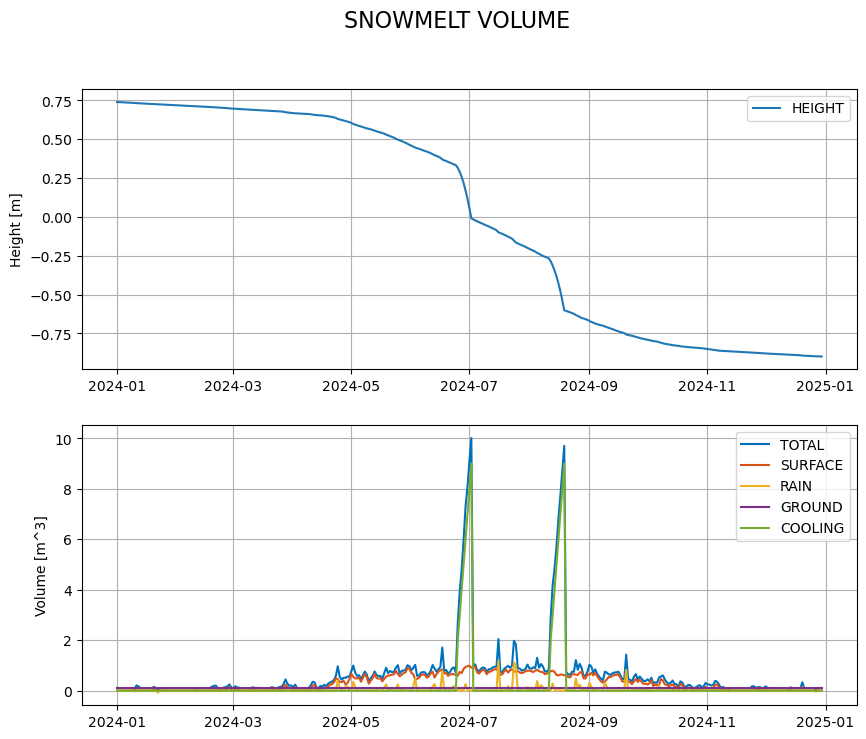

In [57]:
# Plotting results
print('Plotting results...')
# Plot Figure 1
f1, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
f1.suptitle('SNOWMELT VOLUME', fontsize=16)

time = [datetime(2024, 1, 1) + timedelta(days=i) for i in range(num_of_days)]
ax1.plot(time, storeh)
ax1.set_ylabel('Height [m]')
ax1.grid(True)
ax1.legend(['HEIGHT'])

data = Vf2.T
ax2.plot(time, data[:, 0], color='#0072BD', label='TOTAL')
ax2.plot(time, data[:, 2], color='#D95319', label='SURFACE')
ax2.plot(time, data[:, 3], color='#EDB120', label='RAIN')
ax2.plot(time, data[:, 4], color='#7E2F8E', label='GROUND')
ax2.plot(time, data[:, 5], color='#77AC30', label='COOLING')
ax2.set_ylabel('Volume [m^3]')
ax2.grid(True)
ax2.legend()

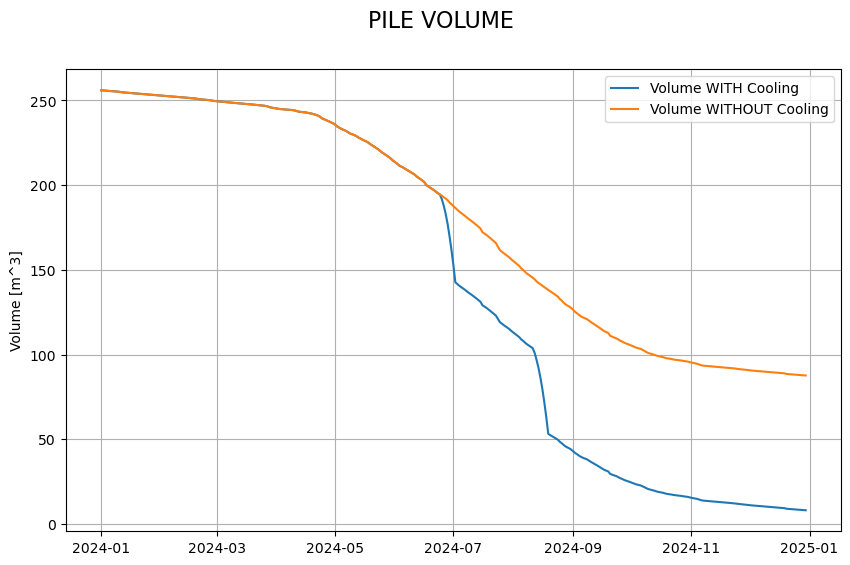

Plotting completed.


In [58]:
# Plot Figure 2
f2, ax3 = plt.subplots(figsize=(10, 6))
f2.suptitle('PILE VOLUME', fontsize=16)

i = np.where(Vnew2 < 0)[0]
if len(i) == 0:
    ax3.plot(time, Vnew2, label='Volume WITH Cooling')
else:
    Vnew2TOP = Vnew2.copy()
    Vnew0LOW = Vnew2.copy()
    Vnew2TOP[i[0]:] = np.nan
    Vnew0LOW[:i[0]] = np.nan
    ax3.plot(time, Vnew2TOP, label='Volume WITH Cooling')
    ax3.plot(time, Vnew0LOW, '--', color=ax3.get_lines()[-1].get_color())

i = np.where(Vnew0 < 0)[0]
if len(i) == 0:
    ax3.plot(time, Vnew0, label='Volume WITHOUT Cooling')
else:
    Vnew0TOP = Vnew0.copy()
    Vnew0LOW = Vnew0.copy()
    Vnew0TOP[i[0]:] = np.nan
    Vnew0LOW[:i[0]] = np.nan
    ax3.plot(time, Vnew0TOP, '.', label='Volume WITHOUT Cooling')
    ax3.plot(time, Vnew0LOW, '--', color=ax3.get_lines()[-1].get_color())

ax3.set_ylabel('Volume [m^3]')
ax3.grid(True)
ax3.legend()

plt.show()
print('Plotting completed.')